Load Preprocessed Data

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load cleaned dataset
fraud_df = pd.read_csv("../data/fraud_data_ready.csv")
print("✅ Loaded preprocessed fraud dataset.")


✅ Loaded preprocessed fraud dataset.


Split Features & Target

In [2]:
# Separate target and features
X = fraud_df.drop(columns=['class'])
y = fraud_df['class']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"✅ Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Fraud ratio in train: {y_train.mean():.4f}, in test: {y_test.mean():.4f}")


✅ Train shape: (120889, 203), Test shape: (30223, 203)
Fraud ratio in train: 0.0936, in test: 0.0936


In [3]:
from imblearn.over_sampling import SMOTE

# Drop non-numeric columns before SMOTE
non_numeric_cols = ['signup_time', 'purchase_time', 'device_id', 'ip_address']
X_train_smote = X_train.drop(columns=non_numeric_cols)

# Apply SMOTE on training data only
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_smote, y_train)

# Show results
print("✅ SMOTE applied.")
print(f"Original training set: {y_train.value_counts().to_dict()}")
print(f"Balanced training set: {y_train_balanced.value_counts().to_dict()}")


✅ SMOTE applied.
Original training set: {0: 109568, 1: 11321}
Balanced training set: {0: 109568, 1: 109568}


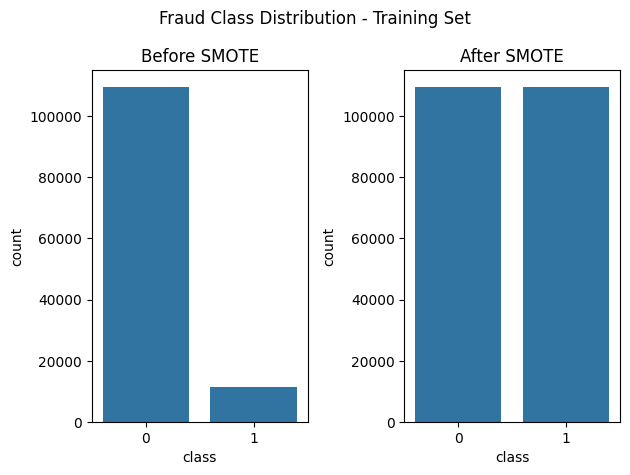

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Before
plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title("Before SMOTE")

# After
plt.subplot(1, 2, 2)
sns.countplot(x=y_train_balanced)
plt.title("After SMOTE")

plt.suptitle("Fraud Class Distribution - Training Set")
plt.tight_layout()
plt.show()


Train Logistic Regression

📊 Evaluation for Logistic Regression:
F1 Score: 0.15780467710247797
Precision: 0.09614642057301723
Recall: 0.43992932862190814
AUC-PR: 0.09602150420430729


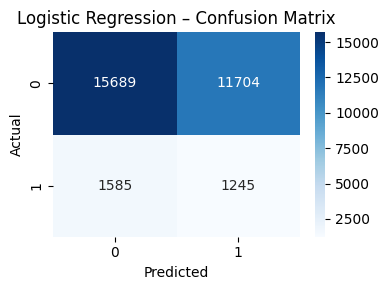


Classification Report:
              precision    recall  f1-score   support

           0     0.9082    0.5727    0.7025     27393
           1     0.0961    0.4399    0.1578      2830

    accuracy                         0.5603     30223
   macro avg     0.5022    0.5063    0.4301     30223
weighted avg     0.8322    0.5603    0.6515     30223



In [5]:
import sys
import os

# Add src to path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))

from model_utils import evaluate_model
from sklearn.linear_model import LogisticRegression


# Train logistic regression on SMOTE-balanced data
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_balanced, y_train_balanced)

# Evaluate on original test set (drop non-numeric columns for consistency)
X_test_numeric = X_test.drop(columns=non_numeric_cols)
evaluate_model(lr_model, X_test_numeric, y_test, model_name="Logistic Regression")


 Train XGBoost (Ensemble Model)

c:\Users\filimon.hailemariam\Downloads\Week 8&9\fraud-detection-ecommerce-banking\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:27:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


📊 Evaluation for XGBoost:
F1 Score: 0.6756982075864943
Precision: 0.8236788617886179
Recall: 0.572791519434629
AUC-PR: 0.6909936745570355


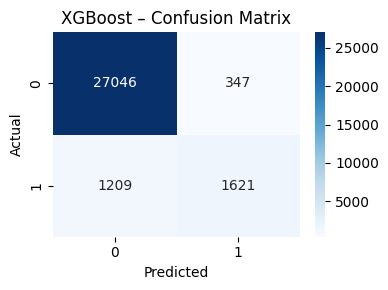


Classification Report:
              precision    recall  f1-score   support

           0     0.9572    0.9873    0.9720     27393
           1     0.8237    0.5728    0.6757      2830

    accuracy                         0.9485     30223
   macro avg     0.8904    0.7801    0.8239     30223
weighted avg     0.9447    0.9485    0.9443     30223



In [6]:
from xgboost import XGBClassifier

# Train XGBoost on SMOTE-balanced data
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    scale_pos_weight=1,  # already balanced via SMOTE
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train_balanced, y_train_balanced)

# Evaluate on original test set (drop non-numeric columns for consistency)
X_test_numeric = X_test.drop(columns=non_numeric_cols)
evaluate_model(xgb_model, X_test_numeric, y_test, model_name="XGBoost")


Train Random Forest (Ensemble Model)

📊 Evaluation for Random Forest:
F1 Score: 0.6268152651131375
Precision: 0.6002587322121604
Recall: 0.6558303886925795
AUC-PR: 0.7041382503147016


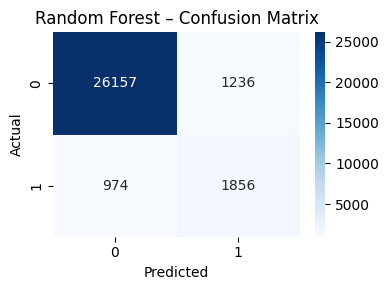


Classification Report:
              precision    recall  f1-score   support

           0     0.9641    0.9549    0.9595     27393
           1     0.6003    0.6558    0.6268      2830

    accuracy                         0.9269     30223
   macro avg     0.7822    0.8054    0.7931     30223
weighted avg     0.9300    0.9269    0.9283     30223



In [7]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest on SMOTE-balanced data
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight=None,  # no need when using SMOTE
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_balanced, y_train_balanced)

# Evaluate on test set (drop non-numeric columns for consistency)
X_test_numeric = X_test.drop(columns=non_numeric_cols)
evaluate_model(rf_model, X_test_numeric, y_test, model_name="Random Forest")


In [8]:
from sklearn.metrics import f1_score, average_precision_score, precision_score, recall_score

# Define function to extract key metrics
def get_scores(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    return {
        "Model": name,
        "F1 Score": f1_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "AUC-PR": average_precision_score(y_test, y_prob) if y_prob is not None else None
    }

# Prepare test set with only numeric columns
X_test_numeric = X_test.drop(columns=non_numeric_cols)

# Gather results
results = [
    get_scores(lr_model, X_test_numeric, y_test, "Logistic Regression"),
    get_scores(xgb_model, X_test_numeric, y_test, "XGBoost"),
    get_scores(rf_model, X_test_numeric, y_test, "Random Forest"),
]

# Display as DataFrame
results_df = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False)
display(results_df)


,Model,F1 Score,Precision,Recall,AUC-PR
1,XGBoost,0.675698,0.823679,0.572792,0.690994
2,Random Forest,0.626815,0.600259,0.655830,0.704138
0,Logistic Regression,0.157805,0.096146,0.439929,0.096022


Interpretation
Logistic Regression performed poorly across all metrics, especially on fraud detection (low recall and AUC-PR). It struggles with complex patterns and non-linear relationships typical in fraud detection tasks.

Random Forest has the highest recall (0.656) and highest AUC-PR (0.704), meaning it catches more fraud cases while balancing overall performance well.

XGBoost has the highest F1 Score (0.676) and best precision (0.824), meaning when it predicts fraud, it’s usually correct—but it misses more frauds (lower recall).

✅ Recommendation
Choose Random Forest if:

You care more about catching as many fraud cases as possible (high recall).

You want a good balance between false positives and false negatives.

Choose XGBoost if:

You want high confidence in the fraud predictions it makes (high precision).

You can tolerate missing some frauds, but can’t afford many false alarms.

💡 Best for Business?
For fraud detection, it's typically more important to minimize false negatives (i.e., not missing frauds). Therefore, Random Forest is a better all-around choice, unless you want to aggressively reduce false positives—in which case XGBoost could be tested further with tunin

In [9]:
import pickle
import os

# 🔐 Ensure models directory exists
os.makedirs("../models", exist_ok=True)

# 🪵 Save Random Forest model
with open("../models/lr_fraud_model.pkl", "wb") as f:
    pickle.dump(lr_model, f)

# 🪵 Save Random Forest model
with open("../models/rf_fraud_model.pkl", "wb") as f:
    pickle.dump(rf_model, f)

# ⚡ Save XGBoost model
with open("../models/xgb_fraud_model.pkl", "wb") as f:
    pickle.dump(xgb_model, f)

print("✅ Saved both models:")


✅ Saved both models:
